# 使用 {mod}`torch.autograd` 进行自动微分

在训练神经网络时，最常用的算法是 **反向传播**。在这个算法中，参数（模型权重）会根据损失函数相对于给定参数的 **梯度** 进行调整。

为了计算这些梯度，PyTorch 有内置的微分引擎称为 {mod}`torch.autograd`。它支持对任何计算图的梯度进行自动计算。

考虑最简单的一层神经网络，输入为 `x`，参数为 `w` 和 `b`，以及某个损失函数。它可以在 PyTorch 中以如下方式定义：

In [1]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## 张量、函数和计算图

这段代码定义了以下**计算图**：

![](https://pytorch.org/tutorials/_static/img/basics/comp-graph.png)

在这个网络中，`w` 和 `b` 是 **参数**，需要优化它们。因此，需要能够计算损失函数对这些变量的梯度。为了做到这一点，设置了这些张量的 `requires_grad` 属性。

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>注意：</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>在创建张量时，你可以设置<code>requires_grad</code>值，或者稍后通过使用<code>x.requires_grad_(True)</code>方法来设定。<p>
</div>



应用于张量以构建计算图的函数实际上是 [`Function` 类的对象](https://pytorch.org/docs/stable/autograd.html#function)。该对象知道如何沿正向计算函数，并且也知道如何在反向传播步骤中计算其导数。反向传播函数的引用存储在张量的 `grad_fn` 属性中。

In [2]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f31a0d80af0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f31a0d81030>


## 计算梯度

为了优化神经网络中的参数权重，需要计算损失函数相对于参数的导数，即需要求出 $\frac{\partial loss}{\partial w}$ 和 $\frac{\partial loss}{\partial b}$ 在固定的 `x` 和 `y` 值下的值。为了计算这些导数，调用 `loss.backward()` 方法，然后从 `w.grad` 和 `b.grad` 中检索值：

In [3]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0060, 0.0023, 0.3330],
        [0.0060, 0.0023, 0.3330],
        [0.0060, 0.0023, 0.3330],
        [0.0060, 0.0023, 0.3330],
        [0.0060, 0.0023, 0.3330]])
tensor([0.0060, 0.0023, 0.3330])


```{note}
- 只能获取计算图中叶节点的 `grad` 属性，这些叶节点的 `requires_grad` 属性被设置为 `True`。对于计算图中的其他所有节点，梯度将不可用。
- 出于性能原因，只能对给定的计算图执行一次 `backward` 梯度计算。如果需要在同一个图上进行多次 `backward` 调用，需要在 `backward` 调用中传递 `retain_graph=True`。
```

## 禁用梯度跟踪

默认情况下，所有具有 `requires_grad=True` 的张量都会跟踪其计算历史并支持梯度计算。然而，在某些情况下并不需要这样做，例如当已经训练好模型，只想将其应用于一些输入数据时，即只想通过网络进行 *前向* 计算。可以通过在计算代码周围使用 {func}`torch.no_grad` 块来停止跟踪计算：

In [4]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


另一种达到相同效果的方法是使用 `detach()` 方法对张量进行操作：

In [5]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


可能希望禁用梯度跟踪的原因有：

- 将神经网络中的一些参数标记为 **冻结参数**。
- 当仅进行前向传递时，可以 **加快计算速度**，因为不追踪梯度的张量上的计算会更为高效。

## 计算图

从概念上讲，`autograd` 在有向无环图（DAG）中记录数据（张量）和所有执行的操作（以及生成的新张量），该计算图由[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)对象组成。在这个 DAG 中，叶子节点是输入张量，根节点是输出张量。通过从根到叶遍历这个计算图，你可以使用链式法则自动计算梯度。

在前向传播过程中，`autograd` 同时进行两项工作：

- 运行请求的操作以计算结果张量
- 在 DAG 中维护操作的 *梯度函数*。

当在 DAG 根上调用 `.backward()` 时，后向传播开始。然后，`autograd`：

- 从每个 `.grad_fn` 计算梯度，
- 将它们累加到相应张量的 `.grad` 属性中，
- 并使用链式法则，一直传播到叶张量。

```{note}
DAGs 在 PyTorch 中是动态的。值得注意的是，每次调用 `.backward()` 后，计算图都会从零开始重新构建，`autograd` 会开始填充新的计算图。正是这一点让你能在模型中使用控制流语句；如果需要，你可以在每次迭代时改变形状、大小和操作。
```

## 简单的例子

上面讲了很多理论——但在实践中使用自动微分是什么样子呢？

从简单的例子开始。

In [6]:
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

接下来，创建输入张量，其中包含区间 $[0, \pi]$ 上的均匀间隔值，并指定 `requires_grad=True`。（像大多数创建张量的函数一样，{func}`torch.linspace` 接受可选的 `requires_grad` 选项。）设置此标志意味着在随后的每次计算中，自动微分将在该计算的输出张量中累积计算的历史记录。

In [7]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


接下来，将执行计算，并根据其输入绘制其输出：

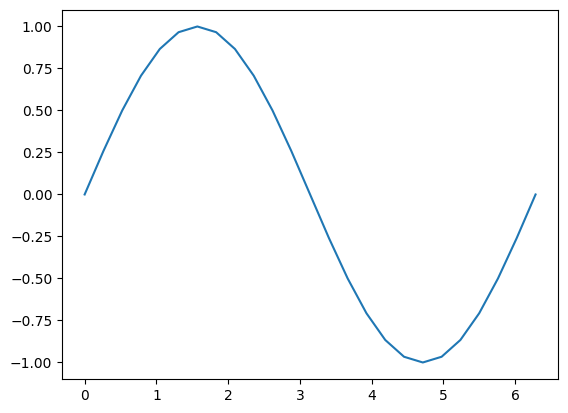

In [8]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach());

仔细看看张量 `b`。当打印它时，看到指示器，表明它正在跟踪其计算历史

In [9]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


此 `grad_fn` 提示当我们执行反向传播步骤并计算梯度时，需要计算此张量所有输入的 $\sin(x)$ 的导数。

执行更多计算：

In [10]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


计算单元素输出。当你在没有参数的情况下对张量调用 `.backward()` 时，它期望调用张量只包含一个元素，就像计算损失函数时一样。

In [11]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


每个与张量一起存储的 `grad_fn` 允许你使用其 `next_functions` 属性一直追溯到其输入。可以在下面看到，在 `d` 上钻取此属性显示了所有先前张量的梯度函数。请注意，`a.grad_fn` 报告为 `None`，这表明这是函数的输入，没有自己的历史记录。

In [12]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f318855f3a0>, 0), (None, 0))
((<SinBackward0 object at 0x7f3188663940>, 0), (None, 0))
((<AccumulateGrad object at 0x7f32e9561510>, 0),)
()

c:

b:

a:
None


对输出调用 `backward()` 方法，并检查输入的 `grad` 属性以检查梯度

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


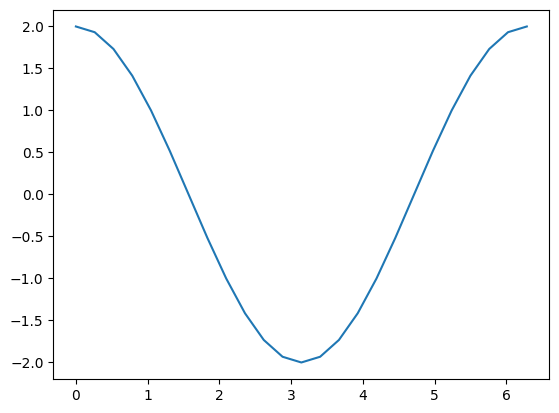

In [13]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach());

## 可选阅读：张量梯度和雅可比积

在许多情况下，有一个标量损失函数，并且需要计算相对于某些参数的梯度。然而，在某些情况下，输出函数是任意的张量。在这种情况下，PyTorch 允许你计算所谓的 **雅可比积**，而不是实际的梯度。

对于向量函数 $\vec{y}=f(\vec{x})$，其中 $\vec{x}=\langle x_1,\dots,x_n\rangle$ 和 $\vec{y}=\langle y_1,\dots,y_m\rangle$，$\vec{y}$ 相对于 $\vec{x}$ 的梯度由 **雅可比矩阵** 给出：

$$\begin{aligned}
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
\end{aligned}$$

PyTorch 允许你计算 **雅可比积** （Jacobian product） $v^T\cdot J$，而不是计算雅可比矩阵本身，对于给定的输入向量 $v=(v_1 \dots v_m)$。这是通过将 $v$ 作为参数调用 `backward` 来实现的。$v$ 的大小应与我们要计算积的原始张量的大小相同：

In [14]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


```{tip}
请注意，当第二次以相同的参数调用 `backward` 函数时，梯度的值是不同的。这是因为在进行 `backward` 传播时，PyTorch **会累加梯度**，也就是说，计算得到的梯度值会被添加到计算图所有叶子节点的 `grad` 属性中。如果你想计算正确的梯度，你需要在此之前将 `grad` 属性归零。在实际训练中，*优化器* 可以帮助我们做到这一点。
```

```{note}
之前调用了不带参数的 `backward()` 函数。这实际上等同于调用 `backward(torch.tensor(1.0))`，这是一种在标量值函数（例如神经网络训练中的损失）情况下计算梯度的有用方法。
```

## 自定义梯度

见 [PyTorch: Defining new autograd functions](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-defining-new-autograd-functions)